In [6]:
import pandas as pd
import logging

logger = logging.getLogger(__name__)
# Load the CSV file
file_path = "full_cohort_data.csv"
df = pd.read_csv(file_path)
target_data = df["day_28_flg"]

In [7]:
# Keep track of columns to be removed
removed_columns = []

# Identify and remove columns that have only 0 (zeros) in them
zero_columns = df.columns[(df == 0).all()]
logger.debug(f"Zero columns: {zero_columns}")
removed_columns.extend(zero_columns)
df = df.loc[:, (df != 0).any(axis=0)]

# Identify and remove columns that have non-numeric values
non_numeric_columns = df.select_dtypes(exclude=[int, float]).columns
removed_columns.extend(non_numeric_columns)
df = df.select_dtypes(include=[int, float])

# Identify and remove columns that have more than 100 missing values
missing_value_columns = df.columns[df.isnull().sum() > 100]
removed_columns.extend(missing_value_columns)
df = df.dropna(thresh=df.shape[0] - 100, axis=1)

# Save the cleaned DataFrame back to the CSV file
df.to_csv(file_path, index=False)

I removed the columns that had only 0 in it.
I removed the columns that had a non-numerical values.
I removed the columns that had more than 100 missing values.
the columns that I removed so far are: 'weight_first', 'bmi', 'service_unit', 'day_icu_intime', 'sepsis_flg', 'po2_first', 'pco2_first, 'days_28_flg'.   

In [8]:
relevant = [
    "",
    "hosp_exp_flg",
    "icu_exp_flg",
    "mort_day_censored",
    "censor_flg",
    "hour_icu_intime",
    "map_1st",
    "hospital_los_day",
    "icu_los_day",
]
print(df.columns)
for column in relevant:
    if column in df.columns:
        removed_columns.append(column)
        df = df.drop(columns=[column])

    #     print(f"Removed column: {column}")
    # else:
    #    print(f"Column not found: {column}")

Index(['aline_flg', 'age', 'gender_num', 'sapsi_first', 'sofa_first',
       'service_num', 'day_icu_intime_num', 'day_28_flg', 'chf_flg',
       'afib_flg', 'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg',
       'stroke_flg', 'mal_flg', 'resp_flg', 'hr_1st', 'temp_1st', 'spo2_1st',
       'abg_count', 'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
       'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
       'creatinine_first', 'missing_flag.1'],
      dtype='object')
Column not found: 
Column not found: hosp_exp_flg
Column not found: icu_exp_flg
Column not found: mort_day_censored
Column not found: censor_flg
Column not found: hour_icu_intime
Column not found: map_1st
Column not found: hospital_los_day
Column not found: icu_los_day


I removed columns that directly indicated survival outcomes. The purpose of the exercise is to predict human survival based on data. These columns give a sure prediction, so I removed them. 
in addition, I removed columns related to the hospitalization process and less related to the patient's chances of surviva.
the columns I removed here are: "hosp_exp_flg", "icu_exp_flg", "mort_day_censored", "censor_flg" ,"hour_icu_intime", 'map_1st' , "hospital_los_day",  "icu_los_day"

In [10]:
from sklearn.impute import IterativeImputer


# Create a flag for missing values

df["missing_flag"] = df.isnull().any(axis=1).astype(int)


# Use multiple imputation

imputer = IterativeImputer(random_state=0)

df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


# Combine the imputed data with the missing flag

df_final = pd.concat([df_imputed, df["missing_flag"]], axis=1)


# Save the updated dataframe

df_final.to_csv(file_path, index=False)


imputer = IterativeImputer(max_iter=10, random_state=0)

df_imputed.fillna(df_imputed.mean(), inplace=True)

In [11]:
import pandas as pd

# Fill missing cells with the mean of each column
df.fillna(df.mean(), inplace=True)

# Save the updated DataFrame back to CSV
df.to_csv("filled_file.csv", index=False)

IterativeImputer is more sophisticated than simple imputation methods like mean or median imputation. It uses the relationships between features to estimate missing values, which can help preserve the overall structure of the data and reduce bias.

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Identify boolean columns
bool_columns = df.select_dtypes(include=["bool"]).columns

# Select only numeric columns excluding boolean columns
numeric_columns = df.select_dtypes(include=[int, float]).columns.difference(
    bool_columns
)

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
df_min_max_scaled = df.copy()
df_min_max_scaled[numeric_columns] = min_max_scaler.fit_transform(df[numeric_columns])

# Save the normalized dataframe back to a CSV file
df_min_max_scaled.to_csv("min_max_scaled_" + file_path, index=False)

for the normalizations of numeric features: I normalize by Min-Max Scaling. I chose to normalize without boolean columns. 

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Prepare the features for dimensionality reduction
X = df_min_max_scaled[numeric_columns]

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])

# Save the PCA transformed data
df_pca.to_csv("pca_transformed_" + file_path, index=False)

# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])

# Save the t-SNE transformed data
df_tsne.to_csv("tsne_transformed_" + file_path, index=False)

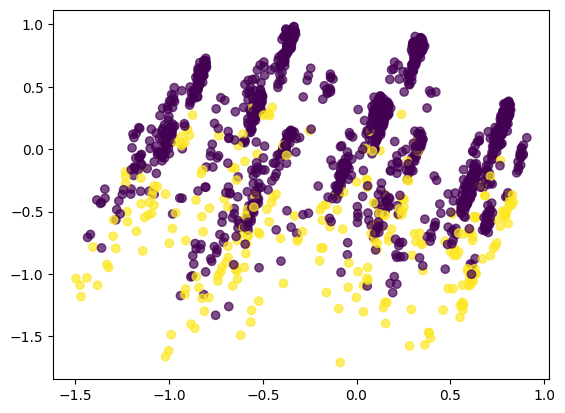

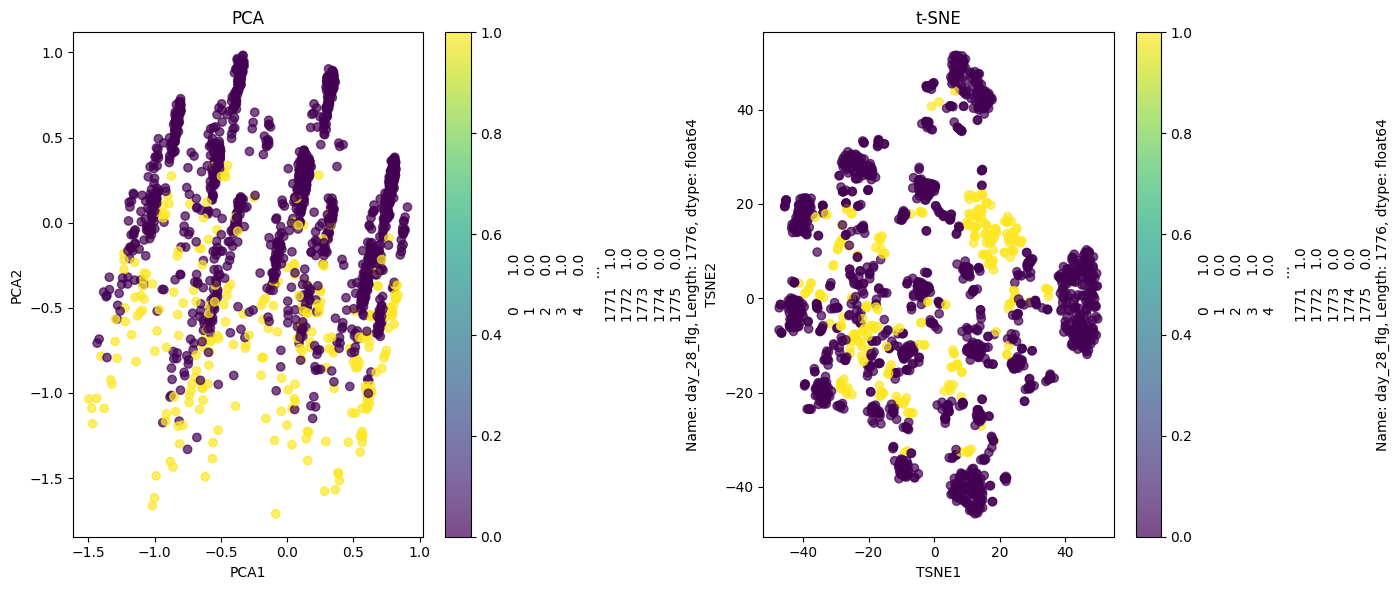

In [19]:
import matplotlib.pyplot as plt

# Plot PCA
scatter = plt.scatter(
    df_pca["PCA1"], df_pca["PCA2"], c=target_data, cmap="viridis", alpha=0.7
)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    df_pca["PCA1"], df_pca["PCA2"], c=target_data, cmap="viridis", alpha=0.7
)
plt.title("PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(scatter, label=target_data)

# Plot t-SNE
plt.subplot(1, 2, 2)
scatter = plt.scatter(
    df_tsne["TSNE1"], df_tsne["TSNE2"], c=target_data, cmap="viridis", alpha=0.7
)
plt.title("t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.colorbar(scatter, label=target_data)

plt.tight_layout()
plt.show()